In [1]:
# !pip install --upgrade plotly plotnine
# !pip install fastinference

In [2]:
import os
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from fastai.tabular.all import * 
# from fastinference.tabular import *
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, SplineTransformer


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

warnings.simplefilter("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
#     os.environ['CUDA_LAUNCH_BLOCKING'] = str(1)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
seed_everything(seed=42)

In [4]:
set_seed(42)
seed_everything(seed=42)

df_train = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_2023071012133740345.csv",parse_dates=['Time'])
df_test = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_202307101549519358.csv",parse_dates=['Time'])
df_cell = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_2023071012130978799.csv",parse_dates=['Time'])
df_bs = pd.read_csv("/kaggle/input/ecm-itu-zindi-kp-data/imgs_2023071012123392536.csv")
df_features = df_cell.merge(df_bs,on=['BS','CellName'],how='outer')
df_features = df_features[df_features['CellName']=='Cell0'].reset_index(drop=True)
df_test['split'] = 'test'
df_train['split'] = 'train'
df_total = pd.concat([df_train,df_test],ignore_index=True)
df_total = df_total.merge(df_features,on=['BS','Time'],how='left')
df_total['ID'] = df_total['Time'].astype(str)+"_"+df_total['BS']
df_total['BS'] = df_total['BS'].str.replace(r'[a-zA-Z_]', '', regex=True).astype(int)
for col in ['RUType','Mode']:
    df_total[col] = df_total[col].str.replace(r'[a-zA-Z]', '', regex=True).astype(int)

df_total.sort_values(['BS','Time'], ascending=True,ignore_index=True,inplace=True)
df_total['day'] = df_total['Time'].dt.day
df_total['weekday_number'] = df_total['Time'].dt.weekday
df_total['hour'] = df_total['Time'].dt.hour

hour_df = df_total[['hour']].copy()
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(splines,columns=[f"hour_spline_{i}" for i in range(splines.shape[1])])
df_total = pd.concat([df_total,splines_df],axis=1)

df_total = df_total.sort_values(['BS','Time'],ascending=True,ignore_index=True)
all_shits = list(np.arange(1,4)) # 
for shift_i in tqdm(all_shits):
    for col in ['load','ESMode1','ESMode2','ESMode3','ESMode6','Time','Energy']:
        df_total[f'{col}_T-{shift_i}'] = df_total.groupby(['BS'])[col].shift(shift_i)        
for shift_i in tqdm(all_shits):
    df_total[f'Time_T-{shift_i}_hours_elapsed'] = (df_total[f'Time_T-{shift_i}']-df_total['Time']).dt.total_seconds() / 3600
    del df_total[f'Time_T-{shift_i}']
print(df_total.shape)

num_bins = 100
df_total['load_bin'] = pd.cut(df_total['load'],bins=[round(i,2) for i in list(np.arange(0,1.01,0.01))],labels=[f'{i}' for i in range(num_bins)])
df_total['load_bin'] = df_total['load_bin'].astype(float).fillna(-1).astype(int)

print(df_total.shape)


100%|██████████| 3/3 [00:00<00:00, 328.24it/s]

(118768, 56)
(118768, 57)


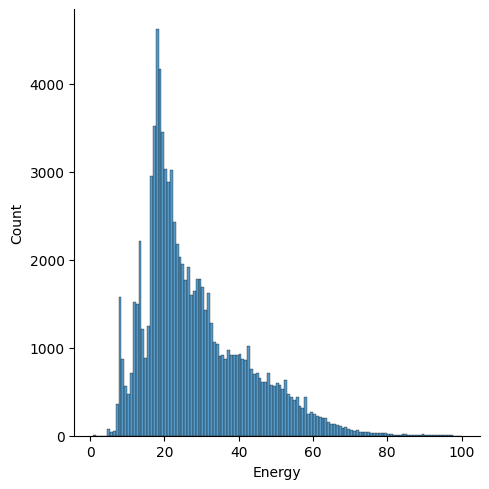

In [5]:
sns.displot(df_total['Energy'])

<Axes: xlabel='Time'>

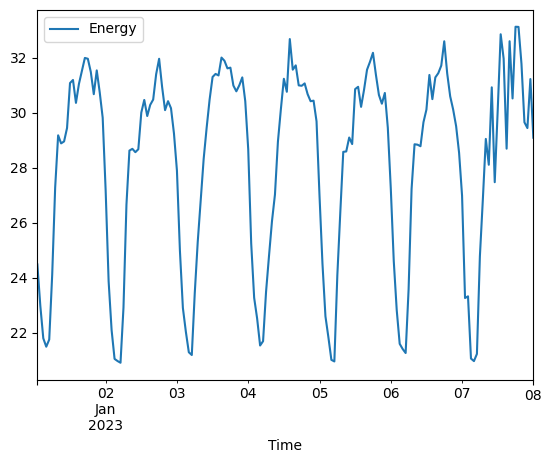

In [6]:
df_total.groupby(['Time'])[['Energy']].mean().plot()

<Axes: xlabel='load'>

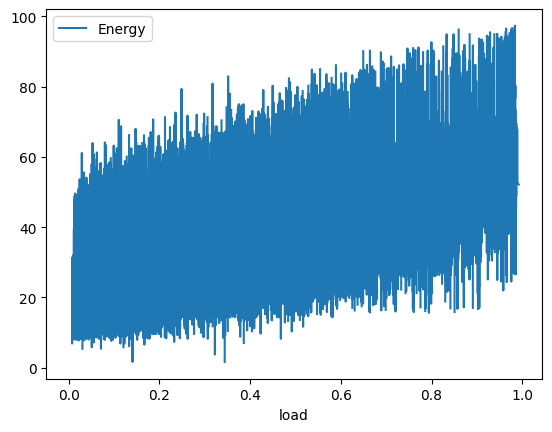

In [7]:
df_total.groupby(['load'])[["Energy"]].mean().plot()

In [8]:
set_seed(42)
seed_everything(seed=42)

from scipy.signal import savgol_filter as sg
from scipy.signal import sosfiltfilt, butter, sosfilt, sosfilt_zi

def add_sg(df):
    w = 5 #5
    p = 3 #2
    for si in tqdm(df.BS.unique()):
        index = df.BS == si
        df.loc[index, 'load_smooth'] = sg(df[index].load, w, p)
        df.loc[index, 'load_diff'] = sg(df[index].load, w, p, 1)
        df.loc[index, 'load_diff2'] = sg(df[index].load, w, p, 2)
        df.loc[index, 'load_diff3'] = sg(df[index].load, w, p, 3)

add_sg(df_total)
print(df_total.shape)

def add_sosfiltfilt(df):
    for si in tqdm(df.BS.unique()):
        index = df.BS == si
        sos=butter(4, 0.125, output='sos')
        sos8 = butter(8, 0.125, output='sos')
        zi = np.array(df[index].load[:4]).mean() * sosfilt_zi(sos8)
        df.loc[index, 'load_sosfiltfilt'] = sosfiltfilt(sos,df[index].load)
        df.loc[index, 'load_sosfilt'], _ = sosfilt(sos8, df[index].load, zi=zi)

add_sosfiltfilt(df_total)
print(df_total.shape)

100%|██████████| 1020/1020 [00:06<00:00, 166.38it/s]


(118768, 61)


100%|██████████| 1020/1020 [00:05<00:00, 195.14it/s]

(118768, 63)


In [9]:
set_seed(42)
seed_everything(seed=42)

df_total.drop(columns=['w','CellName','ESMode4','Time'],inplace=True)

id_variable = 'ID'
version_nb = 'v4'
TARGET = 'Energy'

train_df = df_total[df_total['split']=='train'].reset_index(drop=True)
test_df = df_total[df_total['split']=='test'].reset_index(drop=True)
train_cols = [i for i in train_df if i not in ['Time','CellName','ID','Energy','split','w','BS','ESMode6']]

categorical_cols = ['RUType','Mode','load_bin']

print(train_df[train_cols].shape, test_df[train_cols].shape)

(92629, 54) (26139, 54)


In [10]:
set_seed(42)
seed_everything(seed=42)

remove_non_unique_cols = []
print('train single values ..')
for col in train_df:
    if col in train_cols and col not in ['ESMode5']:
        if train_df[col].nunique()<=1:
            remove_non_unique_cols.append(col)
            print(col,":",train_df[col].nunique())
print('test single values ..')
for col in test_df:
    if col in train_cols and col not in ['ESMode5']:
        if test_df[col].nunique()<=1:
            remove_non_unique_cols.append(col)
            print(col,":",test_df[col].nunique())

print('\n',remove_non_unique_cols)

for col in train_df:
    if col in train_cols:
        if train_df[col].isnull().sum()/len(train_df)>=0.95:
            print(col,":",train_df[col].isnull().sum()/len(train_df))
            remove_non_unique_cols.append(col)

for col in test_df:
    if col in train_cols:
        if test_df[col].isnull().sum()/len(test_df)>=0.95:
            print(col,":",test_df[col].isnull().sum()/len(test_df))
            remove_non_unique_cols.append(col)
            
print(len(train_cols))
train_cols = [col for col in train_cols if col not in remove_non_unique_cols]
print(len(train_cols))
print(train_cols)


train single values ..
test single values ..

 []
54
54
['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode5', 'RUType', 'Mode', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'day', 'weekday_number', 'hour', 'hour_spline_0', 'hour_spline_1', 'hour_spline_2', 'hour_spline_3', 'hour_spline_4', 'hour_spline_5', 'hour_spline_6', 'hour_spline_7', 'hour_spline_8', 'hour_spline_9', 'hour_spline_10', 'hour_spline_11', 'load_T-1', 'ESMode1_T-1', 'ESMode2_T-1', 'ESMode3_T-1', 'ESMode6_T-1', 'Energy_T-1', 'load_T-2', 'ESMode1_T-2', 'ESMode2_T-2', 'ESMode3_T-2', 'ESMode6_T-2', 'Energy_T-2', 'load_T-3', 'ESMode1_T-3', 'ESMode2_T-3', 'ESMode3_T-3', 'ESMode6_T-3', 'Energy_T-3', 'Time_T-1_hours_elapsed', 'Time_T-2_hours_elapsed', 'Time_T-3_hours_elapsed', 'load_bin', 'load_smooth', 'load_diff', 'load_diff2', 'load_diff3', 'load_sosfiltfilt', 'load_sosfilt']


In [11]:
set_seed(42)
seed_everything(seed=42)

Nfold = 10
Inference=False

if Inference:
    print('Data has been splitted...')
else:
    train_df['fold'] = 0
    strafy_bin = train_df['BS'].astype('int')

    skf = GroupKFold(n_splits = Nfold)
    for i, (_, train_index) in enumerate(skf.split(train_df.index,train_df.index, strafy_bin)):
        train_df.loc[train_index, 'fold'] = i  

### FastAI model

In [12]:
set_seed(42)
seed_everything(seed=42)

def mae(preds, targs):
    x = (targs-preds)
    return (abs(x)).mean()

def mape(preds, targs):
    x = (targs-preds)/targs
    return (abs(x)).mean()

def fit_fastai(Nfolds, train_df, test_df, train_cols, cat_feats, TARGET, model_path):
    
    oof_pred_fastai = np.zeros(train_df.shape[0], dtype=np.float32)
    pred_fastai = np.zeros(test_df.shape[0], dtype=np.float32)
    scores = []
    scores_pvt = []
    
    train_df_fast = train_df[train_cols + [TARGET]].copy()
    test_df = test_df.copy()
    for col in train_df_fast.columns:
        if col not in cat_feats:
            train_df_fast[col] = train_df_fast[col].fillna(0)
            test_df[col] = test_df[col].fillna(0)
        else:
            # Impute missing categorical values with the most frequent category
            most_frequent_category = train_df_fast[col].mode().iloc[0]
            train_df_fast[col] = train_df_fast[col].fillna(most_frequent_category)
            test_df[col] = test_df[col].fillna(most_frequent_category)

    train_df_fast[cat_feats] = train_df_fast[cat_feats].astype('category')
    test_df[cat_feats] = test_df[cat_feats].astype('category')
    
    cont_nn = train_cols.copy()
    for col in cat_feats:
        cont_nn.remove(col)

    cat_nn = cat_feats

    layers =  [256, 512, 1024, 512, 256] #[256, 512, 1024, 512, 256]

    val_pct, tst_preds = L(), L()

    for fold in range(Nfolds):
        print("*"*10, f'Fold-{fold+1}', "*"*10)
        train_idx = train_df.loc[train_df['fold']!=fold, :].index
        valid_idx = train_df.loc[train_df['fold']==fold, :].index
        splits = (L(list(train_idx)), L(list(valid_idx)))
        dls = TabularPandas(train_df_fast, [Categorify, Normalize], cat_nn, cont_nn, splits = splits, y_names=TARGET,reduce_memory=False).dataloaders(1024)
        learn = tabular_learner(dls, layers=layers, n_out=1, y_range = (0,100),loss_func = mae, metrics=AccumMetric(mae))
#         print(learn.summary())
#         learn.lr_find(suggest_funcs=(slide, valley))
#         if os.path.isfile(model_path + f'models/nn_model_{fold}.pth'):
#             learn = tabular_learner(dls, layers=layers, n_out=1, path = model_path)
#             learn.load(f'nn_model_{fold}')
#         else:
        learn.fit_one_cycle(100, 2e-3, cbs=SaveModelCallback(monitor='mae', comp=np.less, fname=f'nn_model_{fold}'))

        val_df = train_df.loc[train_df['fold']==fold]
        val_dl = dls.test_dl(val_df[train_cols].fillna(0))
        
        preds, _ = learn.get_preds(dl=val_dl)
        oof_pred_fastai[val_df.index] = preds.squeeze().numpy()
       
        score = mean_absolute_error(val_df[TARGET], oof_pred_fastai[val_df.index])
        score_pvt = mean_absolute_percentage_error(val_df[TARGET], oof_pred_fastai[val_df.index])
        
        scores.append(score)
        scores_pvt.append(score_pvt)
        print(f'MAE for Fold-{fold+1}:', np.round(score, 3))
        print(f'MAPE for Fold-{fold+1}:', np.round(score_pvt, 3))
        
        test_dl = dls.test_dl(test_df[train_cols])
        preds, _ = learn.get_preds(dl=test_dl)
        pred_fastai += preds.squeeze().numpy()/Nfolds

#         display(test_df[train_cols].iloc[-5:])
        
#         exp = ShapInterpretation(learn, test_df[train_cols].iloc[-5:])
#         exp.summary_plot()


    score = mean_absolute_error(train_df[TARGET],oof_pred_fastai)
    score_pvt = mean_absolute_percentage_error(train_df[TARGET],oof_pred_fastai)
    
    print(f'OOF MAE:', np.round(score, 3))
    print(f'Average MAE:', f'{np.round(np.mean(scores), 3)}+/-{np.round(np.std(scores), 3)}')
    
    print(f'OOF MAPE:', np.round(score_pvt, 3))
    print(f'Average MAPE:', f'{np.round(np.mean(scores_pvt), 3)}+/-{np.round(np.std(scores_pvt), 3)}')

    return oof_pred_fastai, pred_fastai

In [13]:
set_seed(42)
seed_everything(seed=42)

if Inference:
    model_path = '../input/ecm-output-of-final-notebook/'
else:
    model_path = './'

oof_pred_fastai, pred_fastai = fit_fastai(Nfold, train_df, test_df, train_cols, categorical_cols, TARGET, model_path)

train_df = train_df.copy()
train_df['oof_fastai'] = oof_pred_fastai

********** Fold-1 **********


epoch,train_loss,valid_loss,mae,time
0,9.456817,6.349920,6.349921,00:03
1,6.526755,4.211842,4.211842,00:01
2,5.179759,3.728648,3.728648,00:00
3,4.304284,3.278872,3.278872,00:00
4,3.755949,3.024884,3.024884,00:00
5,3.723711,3.111871,3.111871,00:00
6,3.607093,2.745358,2.745358,00:01
7,3.538596,2.832667,2.832667,00:01
8,3.357962,2.479171,2.479171,00:00
9,3.207158,2.756423,2.756423,00:00


Better model found at epoch 0 with mae value: 6.349920749664307.
Better model found at epoch 1 with mae value: 4.211842060089111.
Better model found at epoch 2 with mae value: 3.7286477088928223.
Better model found at epoch 3 with mae value: 3.278871774673462.
Better model found at epoch 4 with mae value: 3.0248842239379883.
Better model found at epoch 6 with mae value: 2.7453579902648926.
Better model found at epoch 8 with mae value: 2.4791712760925293.
Better model found at epoch 10 with mae value: 2.1995978355407715.
Better model found at epoch 11 with mae value: 2.128817558288574.
Better model found at epoch 12 with mae value: 1.9076170921325684.
Better model found at epoch 14 with mae value: 1.3882628679275513.
Better model found at epoch 15 with mae value: 1.3190016746520996.
Better model found at epoch 16 with mae value: 0.9919068217277527.
Better model found at epoch 24 with mae value: 0.947580873966217.
Better model found at epoch 30 with mae value: 0.9330751895904541.
Better 

MAE for Fold-1: 0.708
MAPE for Fold-1: 0.025


********** Fold-2 **********


epoch,train_loss,valid_loss,mae,time
0,10.017571,6.952042,6.952042,00:00
1,6.771524,4.908609,4.908609,00:01
2,5.242905,3.516562,3.516562,00:00
3,4.053972,2.910455,2.910455,00:00
4,3.773014,2.980898,2.980898,00:00
5,3.616123,2.870245,2.870246,00:01
6,3.439008,2.528094,2.528094,00:00
7,3.443260,2.696085,2.696085,00:00
8,3.264459,2.244734,2.244734,00:00
9,3.027125,2.911088,2.911088,00:00


Better model found at epoch 0 with mae value: 6.952042102813721.
Better model found at epoch 1 with mae value: 4.908609390258789.
Better model found at epoch 2 with mae value: 3.5165624618530273.
Better model found at epoch 3 with mae value: 2.9104552268981934.
Better model found at epoch 5 with mae value: 2.8702456951141357.
Better model found at epoch 6 with mae value: 2.5280938148498535.
Better model found at epoch 8 with mae value: 2.2447338104248047.
Better model found at epoch 10 with mae value: 1.890758752822876.
Better model found at epoch 12 with mae value: 1.7324326038360596.
Better model found at epoch 14 with mae value: 1.3060178756713867.
Better model found at epoch 17 with mae value: 1.2852613925933838.
Better model found at epoch 20 with mae value: 1.2488675117492676.
Better model found at epoch 23 with mae value: 0.9727933406829834.
Better model found at epoch 41 with mae value: 0.9477627873420715.
Better model found at epoch 63 with mae value: 0.9270219802856445.
Bette

MAE for Fold-2: 0.781
MAPE for Fold-2: 0.03


********** Fold-3 **********


epoch,train_loss,valid_loss,mae,time
0,10.167727,7.602497,7.602497,00:00
1,7.032835,5.865996,5.865996,00:00
2,5.438140,4.252079,4.252079,00:00
3,4.508999,3.537846,3.537846,00:00
4,3.976124,3.134712,3.134712,00:00
5,3.756448,3.278461,3.278461,00:00
6,3.691345,3.202112,3.202112,00:00
7,3.651780,2.909228,2.909229,00:00
8,3.311339,2.910589,2.910589,00:00
9,3.258248,2.716894,2.716894,00:00


Better model found at epoch 0 with mae value: 7.60249662399292.
Better model found at epoch 1 with mae value: 5.865996360778809.
Better model found at epoch 2 with mae value: 4.252079010009766.
Better model found at epoch 3 with mae value: 3.537846326828003.
Better model found at epoch 4 with mae value: 3.134711503982544.
Better model found at epoch 7 with mae value: 2.909228801727295.
Better model found at epoch 9 with mae value: 2.7168941497802734.
Better model found at epoch 11 with mae value: 2.464730739593506.
Better model found at epoch 13 with mae value: 2.2429206371307373.
Better model found at epoch 15 with mae value: 1.5127538442611694.
Better model found at epoch 16 with mae value: 1.2706464529037476.
Better model found at epoch 20 with mae value: 0.993901789188385.
Better model found at epoch 25 with mae value: 0.9312928318977356.
Better model found at epoch 33 with mae value: 0.8274055123329163.
Better model found at epoch 54 with mae value: 0.7605619430541992.
Better mode

MAE for Fold-3: 0.646
MAPE for Fold-3: 0.025


********** Fold-4 **********


epoch,train_loss,valid_loss,mae,time
0,10.797169,9.748543,9.748542,00:01
1,7.044927,7.159775,7.159775,00:00
2,5.289560,4.956552,4.956552,00:00
3,4.332365,4.248137,4.248137,00:00
4,3.817813,3.209848,3.209848,00:01
5,3.610722,3.058182,3.058182,00:00
6,3.374979,3.062462,3.062462,00:00
7,3.294510,2.900050,2.900050,00:00
8,2.757995,1.830666,1.830666,00:00
9,2.615384,1.951364,1.951364,00:00


Better model found at epoch 0 with mae value: 9.748541831970215.
Better model found at epoch 1 with mae value: 7.1597747802734375.
Better model found at epoch 2 with mae value: 4.956551551818848.
Better model found at epoch 3 with mae value: 4.248136520385742.
Better model found at epoch 4 with mae value: 3.2098476886749268.
Better model found at epoch 5 with mae value: 3.0581815242767334.
Better model found at epoch 7 with mae value: 2.900050163269043.
Better model found at epoch 8 with mae value: 1.8306658267974854.
Better model found at epoch 10 with mae value: 1.6357413530349731.
Better model found at epoch 11 with mae value: 1.5931061506271362.
Better model found at epoch 14 with mae value: 1.5327121019363403.
Better model found at epoch 15 with mae value: 1.2888987064361572.
Better model found at epoch 23 with mae value: 1.2453237771987915.
Better model found at epoch 24 with mae value: 1.1759085655212402.
Better model found at epoch 25 with mae value: 1.086789608001709.
Better m

MAE for Fold-4: 0.79
MAPE for Fold-4: 0.027


********** Fold-5 **********


epoch,train_loss,valid_loss,mae,time
0,10.059049,6.380902,6.380902,00:00
1,6.713114,4.516955,4.516955,00:00
2,5.126893,3.678010,3.678010,00:00
3,4.323877,3.328683,3.328683,00:00
4,3.782491,2.768857,2.768857,00:00
5,3.492573,2.376862,2.376862,00:00
6,3.025244,2.168970,2.168970,00:00
7,2.656984,1.669548,1.669547,00:01
8,2.509121,1.763438,1.763439,00:01
9,2.500651,1.998122,1.998122,00:00


Better model found at epoch 0 with mae value: 6.38090181350708.
Better model found at epoch 1 with mae value: 4.516955375671387.
Better model found at epoch 2 with mae value: 3.678009510040283.
Better model found at epoch 3 with mae value: 3.3286828994750977.
Better model found at epoch 4 with mae value: 2.7688567638397217.
Better model found at epoch 5 with mae value: 2.376862049102783.
Better model found at epoch 6 with mae value: 2.1689698696136475.
Better model found at epoch 7 with mae value: 1.6695473194122314.
Better model found at epoch 11 with mae value: 1.4130768775939941.
Better model found at epoch 14 with mae value: 1.1625803709030151.
Better model found at epoch 23 with mae value: 0.9935506582260132.
Better model found at epoch 29 with mae value: 0.9407601356506348.
Better model found at epoch 38 with mae value: 0.8928316235542297.
Better model found at epoch 40 with mae value: 0.8566378355026245.
Better model found at epoch 51 with mae value: 0.8285734057426453.
Better m

MAE for Fold-5: 0.691
MAPE for Fold-5: 0.026


********** Fold-6 **********


epoch,train_loss,valid_loss,mae,time
0,10.321075,7.141307,7.141307,00:00
1,6.935143,5.777171,5.777171,00:00
2,5.342429,4.586880,4.586880,00:00
3,4.431265,4.166836,4.166836,00:00
4,3.830432,3.986797,3.986797,00:00
5,3.619912,3.826002,3.826002,00:00
6,3.550987,3.656565,3.656565,00:01
7,3.376337,3.845668,3.845668,00:01
8,3.310631,3.487045,3.487045,00:00
9,3.251078,3.648043,3.648043,00:00


Better model found at epoch 0 with mae value: 7.141307353973389.
Better model found at epoch 1 with mae value: 5.7771711349487305.
Better model found at epoch 2 with mae value: 4.586879730224609.
Better model found at epoch 3 with mae value: 4.166836261749268.
Better model found at epoch 4 with mae value: 3.986797332763672.
Better model found at epoch 5 with mae value: 3.8260021209716797.
Better model found at epoch 6 with mae value: 3.6565654277801514.
Better model found at epoch 8 with mae value: 3.4870448112487793.
Better model found at epoch 10 with mae value: 3.1956794261932373.
Better model found at epoch 12 with mae value: 2.489586591720581.
Better model found at epoch 13 with mae value: 2.0386369228363037.
Better model found at epoch 14 with mae value: 1.8119661808013916.
Better model found at epoch 15 with mae value: 1.6281590461730957.
Better model found at epoch 17 with mae value: 1.2589645385742188.
Better model found at epoch 20 with mae value: 1.1849983930587769.
Better m

MAE for Fold-6: 0.751
MAPE for Fold-6: 0.035


********** Fold-7 **********


epoch,train_loss,valid_loss,mae,time
0,10.506797,9.349718,9.349719,00:00
1,7.016289,6.224902,6.224901,00:01
2,5.663968,5.357358,5.357358,00:01
3,4.567714,3.796411,3.796411,00:00
4,4.024645,3.620268,3.620268,00:00
5,3.716016,3.435146,3.435146,00:01
6,3.448395,3.166633,3.166633,00:00
7,3.216831,2.790354,2.790353,00:01
8,3.322335,2.673064,2.673064,00:00
9,2.941935,2.353942,2.353942,00:00


Better model found at epoch 0 with mae value: 9.349719047546387.
Better model found at epoch 1 with mae value: 6.22490119934082.
Better model found at epoch 2 with mae value: 5.357357978820801.
Better model found at epoch 3 with mae value: 3.79641056060791.
Better model found at epoch 4 with mae value: 3.620267629623413.
Better model found at epoch 5 with mae value: 3.435145616531372.
Better model found at epoch 6 with mae value: 3.166633129119873.
Better model found at epoch 7 with mae value: 2.790353298187256.
Better model found at epoch 8 with mae value: 2.6730642318725586.
Better model found at epoch 9 with mae value: 2.353942394256592.
Better model found at epoch 11 with mae value: 2.063297748565674.
Better model found at epoch 14 with mae value: 1.34196138381958.
Better model found at epoch 15 with mae value: 1.2280406951904297.
Better model found at epoch 16 with mae value: 1.1309397220611572.
Better model found at epoch 19 with mae value: 1.1018973588943481.
Better model found 

MAE for Fold-7: 0.746
MAPE for Fold-7: 0.025


********** Fold-8 **********


epoch,train_loss,valid_loss,mae,time
0,9.615080,6.959351,6.959351,00:00
1,6.421461,5.209568,5.209567,00:00
2,4.981572,4.131376,4.131376,00:00
3,4.251060,4.032043,4.032043,00:00
4,3.742053,3.374114,3.374114,00:01
5,3.413600,3.176762,3.176762,00:00
6,3.178507,3.221071,3.221072,00:01
7,2.997388,2.611778,2.611778,00:00
8,2.644730,2.379006,2.379006,00:00
9,2.481716,2.007166,2.007166,00:00


Better model found at epoch 0 with mae value: 6.959351062774658.
Better model found at epoch 1 with mae value: 5.209567070007324.
Better model found at epoch 2 with mae value: 4.131376266479492.
Better model found at epoch 3 with mae value: 4.032042980194092.
Better model found at epoch 4 with mae value: 3.3741135597229004.
Better model found at epoch 5 with mae value: 3.1767618656158447.
Better model found at epoch 7 with mae value: 2.6117775440216064.
Better model found at epoch 8 with mae value: 2.3790056705474854.
Better model found at epoch 9 with mae value: 2.0071659088134766.
Better model found at epoch 10 with mae value: 1.8366389274597168.
Better model found at epoch 14 with mae value: 1.6637622117996216.
Better model found at epoch 16 with mae value: 1.1906346082687378.
Better model found at epoch 22 with mae value: 1.1431353092193604.
Better model found at epoch 28 with mae value: 1.128127098083496.
Better model found at epoch 34 with mae value: 1.0027124881744385.
Better mo

MAE for Fold-8: 0.689
MAPE for Fold-8: 0.025


********** Fold-9 **********


epoch,train_loss,valid_loss,mae,time
0,9.950379,7.031493,7.031493,00:00
1,6.634106,5.002737,5.002737,00:00
2,5.247873,3.828521,3.828521,00:00
3,4.347271,3.536563,3.536563,00:00
4,3.772502,3.400855,3.400855,00:00
5,3.703294,3.246887,3.246887,00:00
6,3.697301,3.135875,3.135875,00:01
7,3.571564,3.491164,3.491164,00:00
8,3.219327,2.884135,2.884135,00:00
9,3.162643,2.611609,2.611609,00:00


Better model found at epoch 0 with mae value: 7.031492710113525.
Better model found at epoch 1 with mae value: 5.002737045288086.
Better model found at epoch 2 with mae value: 3.8285205364227295.
Better model found at epoch 3 with mae value: 3.53656268119812.
Better model found at epoch 4 with mae value: 3.40085506439209.
Better model found at epoch 5 with mae value: 3.246886730194092.
Better model found at epoch 6 with mae value: 3.1358747482299805.
Better model found at epoch 8 with mae value: 2.8841350078582764.
Better model found at epoch 9 with mae value: 2.6116089820861816.
Better model found at epoch 10 with mae value: 2.402879476547241.
Better model found at epoch 12 with mae value: 2.032517671585083.
Better model found at epoch 13 with mae value: 1.8262768983840942.
Better model found at epoch 14 with mae value: 1.449995994567871.
Better model found at epoch 15 with mae value: 1.3392363786697388.
Better model found at epoch 16 with mae value: 1.269901990890503.
Better model fo

MAE for Fold-9: 0.675
MAPE for Fold-9: 0.029


********** Fold-10 **********


epoch,train_loss,valid_loss,mae,time
0,10.594398,5.021165,5.021165,00:01
1,7.116370,3.812995,3.812995,00:01
2,5.552407,3.310080,3.310080,00:00
3,4.791626,3.117662,3.117662,00:01
4,4.129464,3.079677,3.079678,00:00
5,3.891649,2.929113,2.929113,00:00
6,3.440039,2.765415,2.765415,00:01
7,2.982450,2.406815,2.406815,00:00
8,2.694833,2.327292,2.327291,00:00
9,2.452182,1.915935,1.915935,00:00


Better model found at epoch 0 with mae value: 5.021164894104004.
Better model found at epoch 1 with mae value: 3.812995433807373.
Better model found at epoch 2 with mae value: 3.310080051422119.
Better model found at epoch 3 with mae value: 3.117661714553833.
Better model found at epoch 4 with mae value: 3.0796775817871094.
Better model found at epoch 5 with mae value: 2.9291133880615234.
Better model found at epoch 6 with mae value: 2.7654147148132324.
Better model found at epoch 7 with mae value: 2.40681529045105.
Better model found at epoch 8 with mae value: 2.327291250228882.
Better model found at epoch 9 with mae value: 1.9159350395202637.
Better model found at epoch 11 with mae value: 1.6270925998687744.
Better model found at epoch 13 with mae value: 1.620103120803833.
Better model found at epoch 14 with mae value: 1.2437366247177124.
Better model found at epoch 19 with mae value: 1.1635982990264893.
Better model found at epoch 21 with mae value: 1.0016601085662842.
Better model 

MAE for Fold-10: 0.68
MAPE for Fold-10: 0.031


OOF MAE: 0.716
Average MAE: 0.716+/-0.046
OOF MAPE: 0.028
Average MAPE: 0.028+/-0.003


In [14]:
set_seed(42)
seed_everything(seed=42)

submission_fastai = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': pred_fastai})
print(submission_fastai.head())
submission_fastai.to_csv(f'submission_fastai.csv', index=False)

                      Time     Energy
0  2023-01-01 06:00:00_B_0  62.765106
1  2023-01-01 11:00:00_B_0  68.255066
2  2023-01-01 12:00:00_B_0  69.561508
3  2023-01-01 13:00:00_B_0  69.703896
4  2023-01-01 23:00:00_B_0  83.915932


In [15]:
# OOF MAE: 0.686
# Average MAE: 0.686+/-0.048
# OOF MAPE: 0.027
# Average MAPE: 0.027+/-0.003

### Keras Model

In [16]:
from tensorflow import keras
from keras import backend as K
import tensorflow as tf

from tensorflow import keras
from keras import backend as K
from keras.backend import sigmoid
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
from keras.backend import sigmoid
from keras import backend as K

set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)


In [17]:
set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

def mean_absolute_error(y_true, y_pred):
         return K.mean(K.abs( (y_true - y_pred)))

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=50, verbose=0,
    mode='min',restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.25, patience=8, verbose=0,
    mode='min')

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

def mish(x, beta = 1):
    return (x * K.tanh(K.softplus(x)))


get_custom_objects().update({'swish': Activation(swish)})
get_custom_objects().update({'mish': Activation(mish)})

In [18]:
set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

def base_model(hidden_units, embedding_size, train_cols, 
               categorical_cols, uniques):

    n_cont=0
    initial_inputs=[]
    for col in categorical_cols:
        temp_input = keras.Input(shape=(1,), name=col)
        n_cont+=1
        initial_inputs.append(temp_input)
        
    num_input = keras.Input(shape=(len(train_cols)-n_cont,), name='num_data')
    initial_inputs.append(num_input)

    #embedding, flatenning and concatenating
    all_inputs=[]
    for i, col in enumerate(categorical_cols):
        temp_embedded = keras.layers.Embedding(int(uniques[col]), embedding_size, 
                                               input_length=1, name=f'{col}_embedding')(initial_inputs[i])
        temp_flattened = keras.layers.Flatten()(temp_embedded)
        all_inputs.append(temp_flattened)
    
    all_inputs.append(num_input)
    out = keras.layers.Concatenate()(all_inputs)
    
    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='swish')(out)

    # A single output: our predicted rating
    out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

    model = keras.Model(inputs = initial_inputs, outputs = out)
    
    return model

In [19]:
set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

def fit_keras_nn(Nfolds, train_df, test_df, train_cols, cat_cols, TARGET, 
                   model_path):
    
    model_name = 'Keras_NN'
    oof_keras = np.zeros(train_df.shape[0])
    pred_keras = np.zeros(test_df.shape[0])
    scores=[]
    scores_pvt = []
    
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df = train_df.fillna(0)
    test_df = test_df.fillna(0)
    
    cont_cols = train_cols.copy()
    uniques={}
    for col in cat_cols:
        cont_cols.remove(col)
        le = LabelEncoder()
        le.fit(pd.concat([train_df[col], test_df[col]]))
        train_df[col] = le.transform(train_df[col].values)
        test_df[col] = le.transform(test_df[col].values)
        uniques[col] = len(pd.concat([train_df[col], test_df[col]], axis=0).unique())
        
    scaler = StandardScaler().fit(pd.concat([train_df[cont_cols], test_df[cont_cols]], axis=0))       
    train_df[cont_cols] = scaler.transform(train_df[cont_cols].values)
    test_df[cont_cols] = scaler.transform(test_df[cont_cols].values)
    
    test_inputs=[]
    for col in cat_cols:
        test_inputs.append(test_df[col].values)
        
    test_inputs.append(test_df[cont_cols].values)
    
    for fold in range(Nfolds):
        
        print("*"*10, f'Fold-{fold+1}', "*"*10,)
      
        X_train = train_df.loc[train_df.fold!=fold, train_cols]
        y_train = train_df.loc[train_df.fold!=fold, TARGET]
        X_val = train_df.loc[train_df.fold==fold, train_cols]
        y_val = train_df.loc[train_df.fold==fold, TARGET]
        
        model = base_model(hidden_units=(256, 512, 1024, 512, 256), embedding_size=16, #16
                           train_cols=train_cols, categorical_cols=cat_cols, 
                          uniques=uniques)
    
        model.compile(
            keras.optimizers.Adam(learning_rate=0.002),
            loss=mean_absolute_error
        )


        train_inputs=[]
        for col in cat_cols:
            train_inputs.append(X_train[col].values)
    
        train_inputs.append(X_train[cont_cols].values)

        val_inputs=[]
        for col in cat_cols:
            val_inputs.append(X_val[col].values)

        val_inputs.append(X_val[cont_cols].values)
        
#         if os.path.isfile(model_path + f'{model_name}_{fold}.h5'):
#             model =  keras.models.load_model(model_path + f'{model_name}_{fold}.h5', 
#                                              custom_objects={'swish': swish, 'Activation': Activation, 
#                                                              'mean_absolute_error':mean_absolute_error})
        
#         else:

        model.fit(train_inputs, 
                  y_train.values,               
                  batch_size=1024,
                  epochs=1000,
                  validation_data=(val_inputs, y_val.values),
                  callbacks=[es, plateau],
                  validation_batch_size=len(y_val),
                  shuffle=True, verbose = 1)

        model.save(f"{model_name}_{fold}.h5")
            
        preds = model.predict(val_inputs).reshape(1,-1)[0]
        
        score = mean_absolute_error(y_val.values, preds)
        score_pvt = mean_absolute_percentage_error(y_val.values, preds)
        scores.append(score)
        scores_pvt.append(score_pvt)
        oof_keras[X_val.index] = preds
        
        print(f'MAE for Fold-{fold+1}:', np.round(score, 3))
        print(f'MAPE for Fold-{fold+1}:', np.round(score_pvt, 3))
        
        pred_keras += model.predict(test_inputs).reshape(1,-1)[0]/Nfolds
        
    score = mean_absolute_error(train_df[TARGET],oof_keras)
    score_pvt = mean_absolute_percentage_error(train_df[TARGET],oof_keras)
    print(f'OOF MAE:', np.round(score, 3))
    print(f'Average MAE:', f'{np.round(np.mean(scores), 3)}+/-{np.round(np.std(scores), 3)}')
    print(f'OOF MAPE:', np.round(score_pvt, 3))
    print(f'Average MAPE:', f'{np.round(np.mean(scores_pvt), 3)}+/-{np.round(np.std(scores_pvt), 3)}')
    
        
    return oof_keras, pred_keras

In [20]:
set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

if Inference:
    model_path = '../input/ecm-output-of-final-notebook/'
else:
    model_path = './'
    
oof_pred_keras, pred_keras = fit_keras_nn(Nfold, train_df, test_df, train_cols, categorical_cols, TARGET, model_path)
train_df = train_df.copy()
train_df['oof_keras'] = oof_pred_keras

********** Fold-1 **********
Epoch 1/1000
82/82 [==============================] - 8s 33ms/step - loss: 5.4211 - val_loss: 3.0744 - lr: 0.0020
Epoch 2/1000
82/82 [==============================] - 1s 11ms/step - loss: 2.4071 - val_loss: 2.1394 - lr: 0.0020
Epoch 3/1000
82/82 [==============================] - 1s 13ms/step - loss: 1.7897 - val_loss: 1.6051 - lr: 0.0020
Epoch 4/1000
82/82 [==============================] - 1s 9ms/step - loss: 1.3474 - val_loss: 1.2088 - lr: 0.0020
Epoch 5/1000
82/82 [==============================] - 1s 8ms/step - loss: 1.2002 - val_loss: 1.1308 - lr: 0.0020
Epoch 6/1000
82/82 [==============================] - 0s 6ms/step - loss: 1.1032 - val_loss: 1.0071 - lr: 0.0020
Epoch 7/1000
82/82 [==============================] - 1s 8ms/step - loss: 1.0502 - val_loss: 0.9708 - lr: 0.0020
Epoch 8/1000
82/82 [==============================] - 0s 6ms/step - loss: 1.0138 - val_loss: 1.0047 - lr: 0.0020
Epoch 9/1000
82/82 [==============================] - 0s 6ms/ste

In [21]:
set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

submission_keras = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': pred_keras})
print(submission_keras.head())
submission_keras.to_csv('submission_keras.csv', index=False)

                      Time     Energy
0  2023-01-01 06:00:00_B_0  62.807578
1  2023-01-01 11:00:00_B_0  68.676697
2  2023-01-01 12:00:00_B_0  70.482396
3  2023-01-01 13:00:00_B_0  69.166243
4  2023-01-01 23:00:00_B_0  82.802210


In [22]:
# OOF MAE: 0.668
# Average MAE: 0.668+/-0.052
# OOF MAPE: 0.025
# Average MAPE: 0.025+/-0.003

### Writing output

In [23]:
set_seed(42)
seed_everything(seed=42)
tf.random.set_seed(42)

w1_fastai = 0.5
w1_keras = 0.5
new_pred_ens = train_df['oof_keras']*w1_keras + train_df['oof_fastai']*w1_fastai 
new_pred_ens_hm = (2*train_df['oof_keras']*train_df['oof_fastai'])/(train_df['oof_keras']+train_df['oof_fastai'])
print(f'OOF MAE ENSEMBLE: {mean_absolute_error(train_df.Energy, new_pred_ens)}')
print(f'OOF MAPE ENSEMBLE: {mean_absolute_percentage_error(train_df.Energy, new_pred_ens)}')

print(f'OOF MAE ENSEMBLE HM: {mean_absolute_error(train_df.Energy, new_pred_ens_hm)}')
print(f'OOF MAPE ENSEMBLE HM: {mean_absolute_percentage_error(train_df.Energy, new_pred_ens_hm)}')

new_test_pred_ens = pred_keras*w1_keras + pred_fastai*w1_fastai
new_test_pred_ens_hm = (2*pred_keras*pred_fastai)/(pred_keras+pred_fastai)

submission_ensemble = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': new_test_pred_ens})
print(submission_ensemble.head())
submission_ensemble.to_csv('submission_ensemble.csv', index=False)

submission_ensemble_hm = pd.DataFrame(data = {'Time': test_df['ID'].values, 'Energy': new_test_pred_ens_hm})
print(submission_ensemble_hm.head())
submission_ensemble_hm.to_csv('submission_ensemble_hm.csv', index=False)



OOF MAE ENSEMBLE: 0.6660360502206929
OOF MAPE ENSEMBLE: 0.02566820240356784
OOF MAE ENSEMBLE HM: 0.664281544608172
OOF MAPE ENSEMBLE HM: 0.02546631302404832
                      Time     Energy
0  2023-01-01 06:00:00_B_0  62.786342
1  2023-01-01 11:00:00_B_0  68.465882
2  2023-01-01 12:00:00_B_0  70.021952
3  2023-01-01 13:00:00_B_0  69.435069
4  2023-01-01 23:00:00_B_0  83.359071
                      Time     Energy
0  2023-01-01 06:00:00_B_0  62.786335
1  2023-01-01 11:00:00_B_0  68.465232
2  2023-01-01 12:00:00_B_0  70.018924
3  2023-01-01 13:00:00_B_0  69.434028
4  2023-01-01 23:00:00_B_0  83.355351
